In [1]:
# Imports de base
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import pandas as pd
from collections import Counter

# Configuration matplotlib pour de beaux graphiques
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ Imports OK")
print(f"PyTorch: {torch.__version__}")
print(f"GPU disponible: {torch.cuda.is_available()}")

✅ Imports OK
PyTorch: 2.5.1+cu121
GPU disponible: True


In [2]:
# Chemin vers le dataset
# En WSL, D:\ devient /mnt/d/
DATA_DIR = Path("/mnt/d/VENV/Recycle moi/dataset")

# Vérifier que le dossier existe
if not DATA_DIR.exists():
    print(f"❌ ERREUR: {DATA_DIR} n'existe pas!")
else:
    print(f"✅ Dataset trouvé: {DATA_DIR}")

# Définir les sous-dossiers
TRAIN_DIR = DATA_DIR / "train"
VALID_DIR = DATA_DIR / "valid"
TEST_DIR = DATA_DIR / "test"

# Lister les classes (noms des sous-dossiers)
CLASSES = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])

print(f"\n📊 Classes détectées ({len(CLASSES)}): {CLASSES}")

✅ Dataset trouvé: /mnt/d/VENV/Recycle moi/dataset

📊 Classes détectées (7): ['cardboard', 'e-waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


In [3]:
def count_images(directory):
    """
    Compte le nombre d'images dans chaque classe d'un répertoire.
    
    Args:
        directory: Chemin vers train/valid/test
    
    Returns:
        dict: {classe: nombre_images}
    """
    counts = {}
    for class_name in CLASSES:
        class_path = directory / class_name
        # Compte les fichiers image (jpg, jpeg, png)
        images = list(class_path.glob("*.jpg")) + \
                 list(class_path.glob("*.jpeg")) + \
                 list(class_path.glob("*.png"))
        counts[class_name] = len(images)
    return counts

# Compter pour chaque split
train_counts = count_images(TRAIN_DIR)
valid_counts = count_images(VALID_DIR)
test_counts = count_images(TEST_DIR)

# Créer un tableau récapitulatif
df_counts = pd.DataFrame({
    'Train': train_counts,
    'Valid': valid_counts,
    'Test': test_counts
})

# Ajouter une ligne TOTAL
df_counts.loc['TOTAL'] = df_counts.sum()

print("📊 DISTRIBUTION DU DATASET")
print("=" * 50)
print(df_counts)
print("=" * 50)

📊 DISTRIBUTION DU DATASET
           Train  Valid  Test
cardboard   1929    241   242
e-waste     2405    300   302
glass       2022    252   254
medical     1565    195   197
metal       2068    258   260
paper       2155    269   270
plastic     2135    266   268
TOTAL      14279   1781  1793


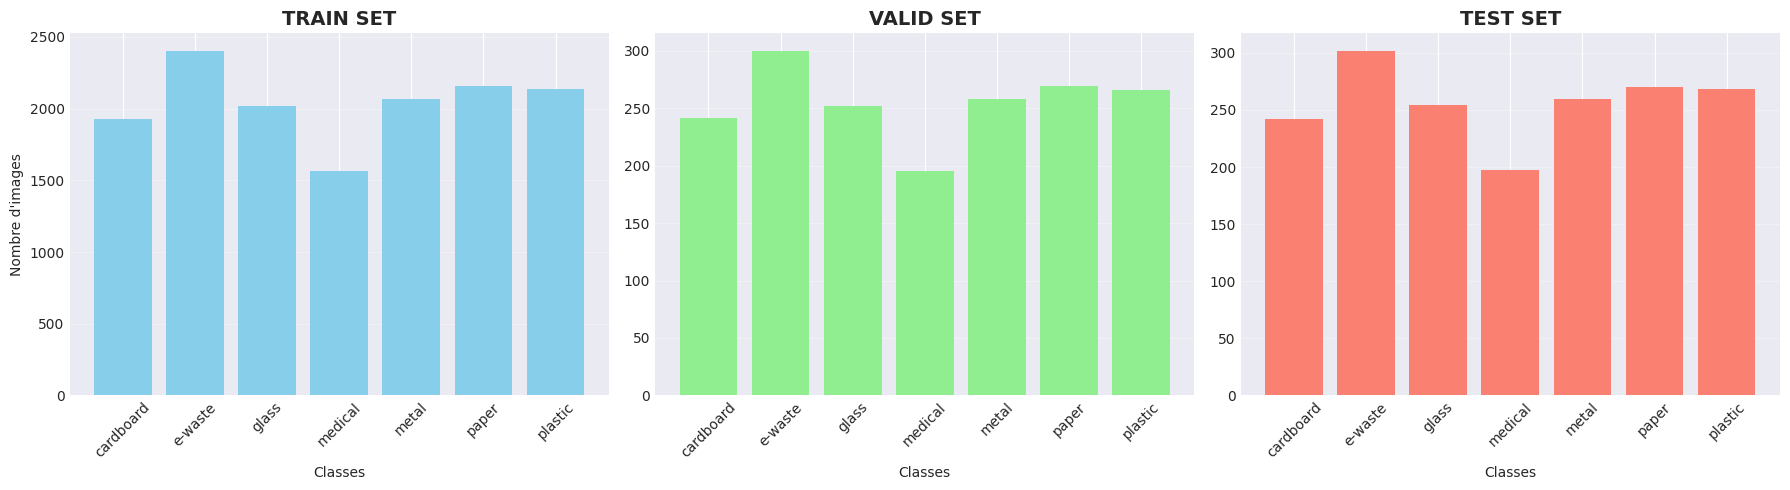

✅ Distribution visualisée


In [4]:
# Graphique : nombre d'images par classe pour chaque split
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train
axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axes[0].set_title('TRAIN SET', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Nombre d\'images')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Valid
axes[1].bar(valid_counts.keys(), valid_counts.values(), color='lightgreen')
axes[1].set_title('VALID SET', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classes')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Test
axes[2].bar(test_counts.keys(), test_counts.values(), color='salmon')
axes[2].set_title('TEST SET', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Classes')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Distribution visualisée")

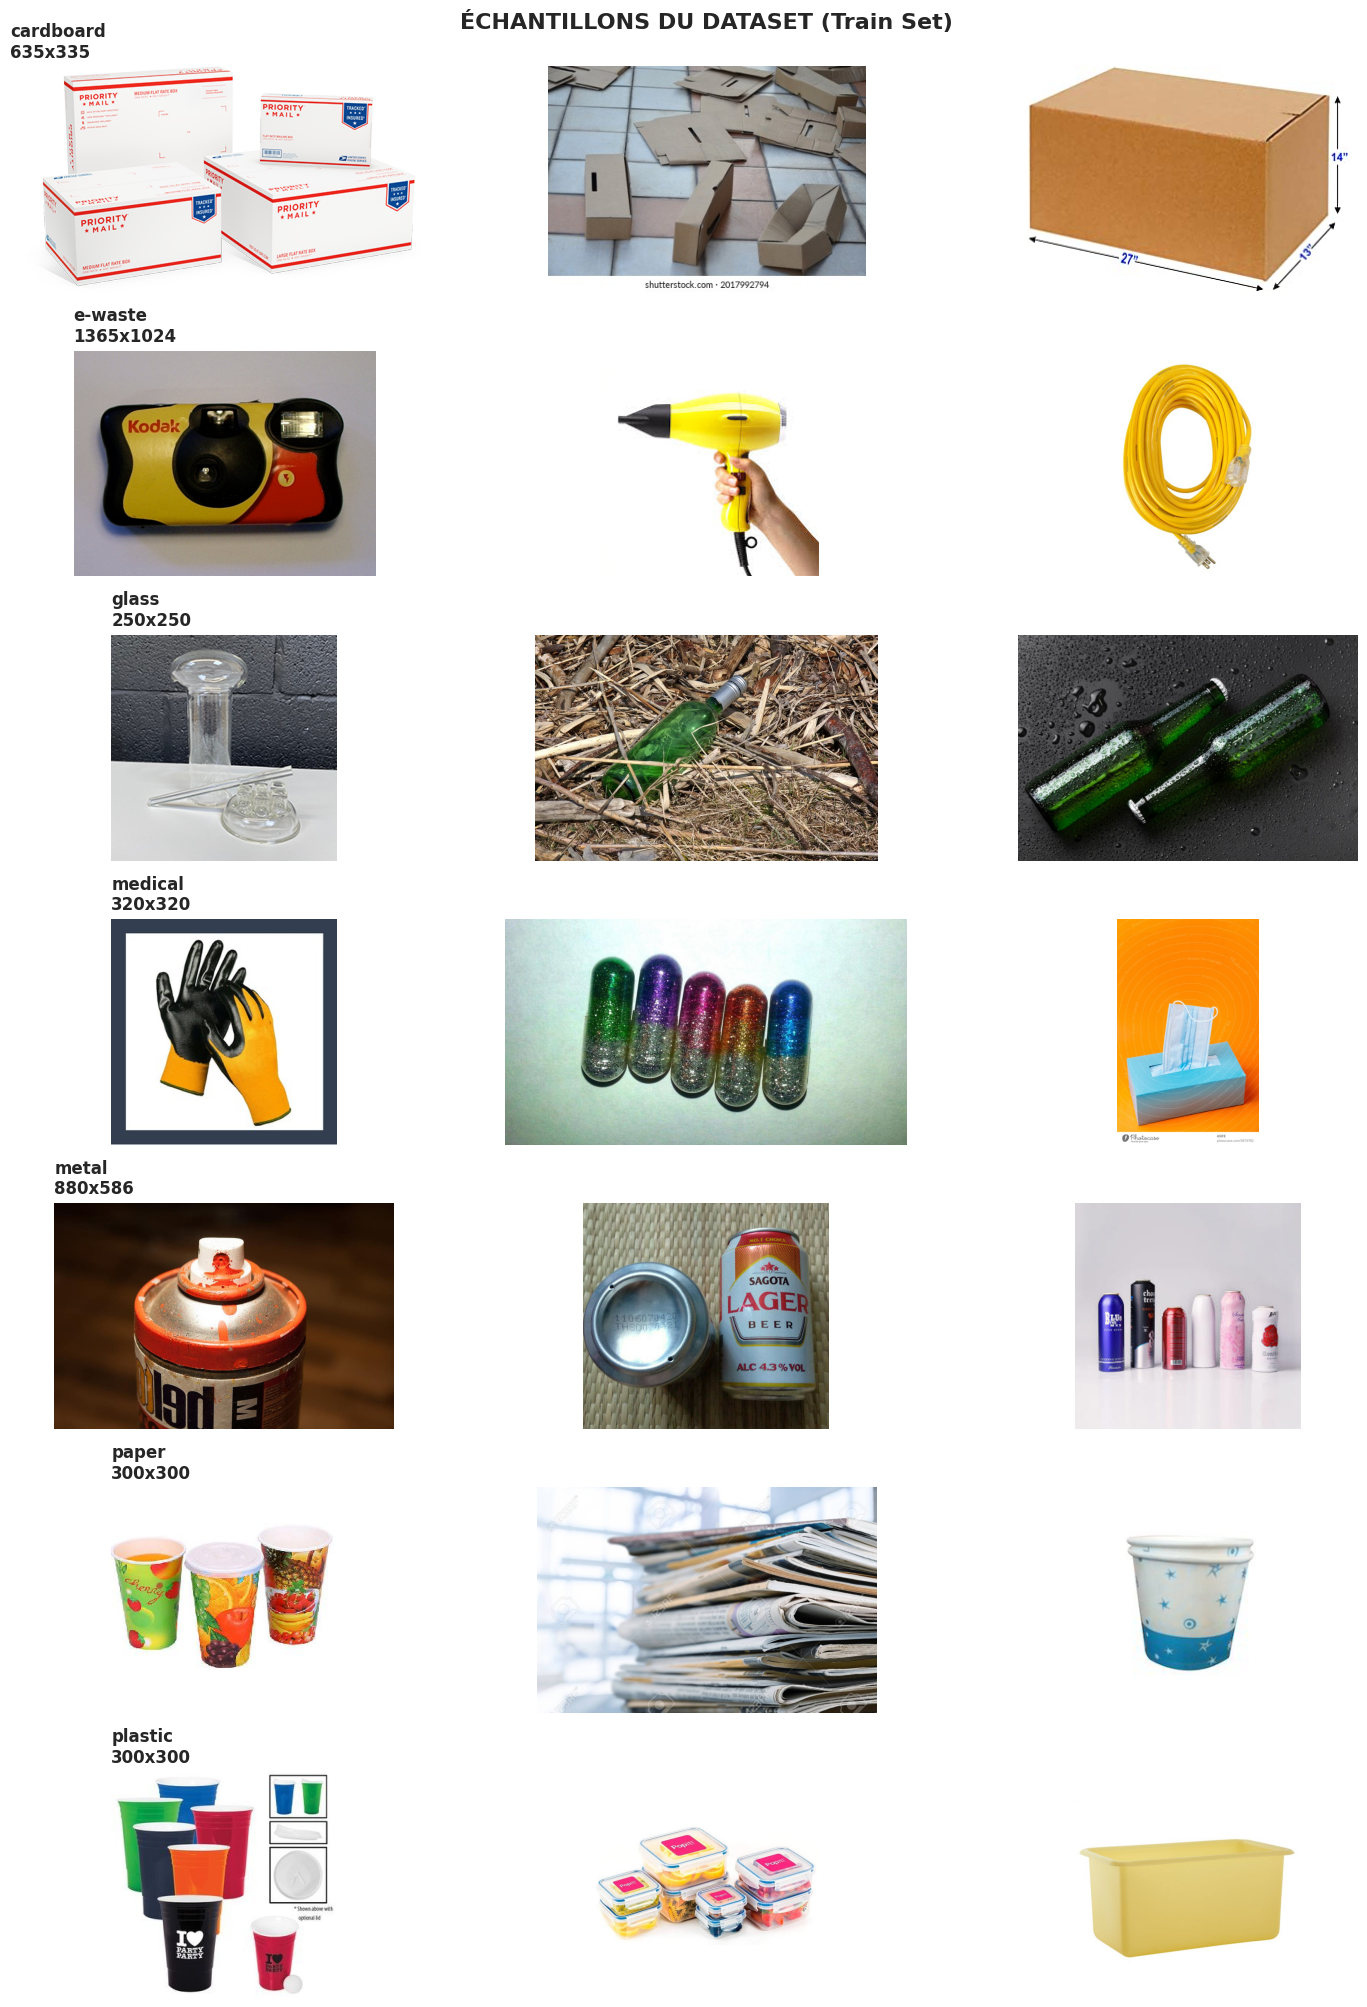

✅ Exemples visualisés


In [5]:
def show_sample_images(n_samples=3):
    """
    Affiche n_samples images aléatoires de chaque classe.
    
    Args:
        n_samples: nombre d'images à afficher par classe
    """
    fig, axes = plt.subplots(len(CLASSES), n_samples, figsize=(15, 20))
    
    for i, class_name in enumerate(CLASSES):
        # Récupérer toutes les images de cette classe
        class_path = TRAIN_DIR / class_name
        images_paths = list(class_path.glob("*.jpg")) + \
                      list(class_path.glob("*.jpeg")) + \
                      list(class_path.glob("*.png"))
        
        # Sélectionner n_samples images aléatoires
        sample_paths = np.random.choice(images_paths, 
                                       size=min(n_samples, len(images_paths)), 
                                       replace=False)
        
        # Afficher chaque image
        for j, img_path in enumerate(sample_paths):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            # Titre uniquement sur la première colonne
            if j == 0:
                axes[i, j].set_title(f"{class_name}\n{img.size[0]}x{img.size[1]}", 
                                    fontsize=12, 
                                    fontweight='bold',
                                    loc='left')
    
    plt.tight_layout()
    plt.suptitle("ÉCHANTILLONS DU DATASET (Train Set)", 
                 fontsize=16, 
                 fontweight='bold',
                 y=1.001)
    plt.show()
    
    print("✅ Exemples visualisés")

# Afficher 3 images par classe
show_sample_images(n_samples=3)

In [6]:
def analyze_image_sizes(directory, sample_size=500):
    """
    Analyse la distribution des tailles d'images.
    
    Args:
        directory: Chemin vers le dataset
        sample_size: nombre d'images à analyser (pour aller plus vite)
    
    Returns:
        dict: statistiques sur les tailles
    """
    widths = []
    heights = []
    aspects = []  # ratios largeur/hauteur
    
    # Parcourir toutes les classes
    for class_name in CLASSES:
        class_path = directory / class_name
        images_paths = list(class_path.glob("*.jpg")) + \
                      list(class_path.glob("*.jpeg")) + \
                      list(class_path.glob("*.png"))
        
        # Échantillonner pour aller plus vite
        sample_paths = np.random.choice(images_paths, 
                                       size=min(sample_size // len(CLASSES), len(images_paths)), 
                                       replace=False)
        
        for img_path in sample_paths:
            try:
                img = Image.open(img_path)
                w, h = img.size
                widths.append(w)
                heights.append(h)
                aspects.append(w / h)
            except Exception as e:
                print(f"⚠️ Erreur avec {img_path}: {e}")
    
    return {
        'widths': widths,
        'heights': heights,
        'aspects': aspects
    }

# Analyser les tailles (sur un échantillon du train set)
print("🔍 Analyse des tailles d'images...")
sizes_stats = analyze_image_sizes(TRAIN_DIR, sample_size=500)

# Statistiques descriptives
print("\n📊 STATISTIQUES DES TAILLES")
print("=" * 50)
print(f"Largeur  - Min: {min(sizes_stats['widths'])}, Max: {max(sizes_stats['widths'])}, Moyenne: {np.mean(sizes_stats['widths']):.0f}")
print(f"Hauteur  - Min: {min(sizes_stats['heights'])}, Max: {max(sizes_stats['heights'])}, Moyenne: {np.mean(sizes_stats['heights']):.0f}")
print(f"Ratio L/H - Min: {min(sizes_stats['aspects']):.2f}, Max: {max(sizes_stats['aspects']):.2f}, Moyenne: {np.mean(sizes_stats['aspects']):.2f}")
print("=" * 50)

🔍 Analyse des tailles d'images...

📊 STATISTIQUES DES TAILLES
Largeur  - Min: 126, Max: 6000, Moyenne: 760
Hauteur  - Min: 91, Max: 5312, Moyenne: 632
Ratio L/H - Min: 0.44, Max: 4.25, Moyenne: 1.25


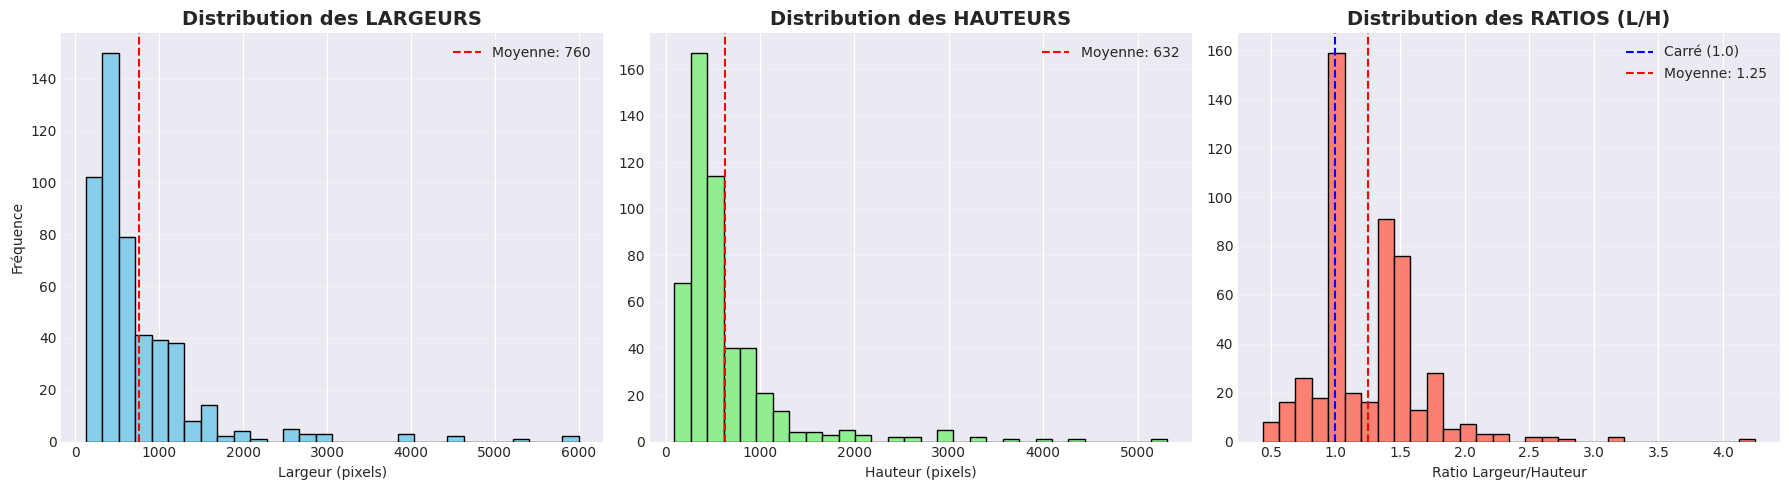

✅ Distributions visualisées


In [7]:
# Graphiques de distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution des largeurs
axes[0].hist(sizes_stats['widths'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution des LARGEURS', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Largeur (pixels)')
axes[0].set_ylabel('Fréquence')
axes[0].axvline(np.mean(sizes_stats['widths']), color='red', linestyle='--', label=f"Moyenne: {np.mean(sizes_stats['widths']):.0f}")
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Distribution des hauteurs
axes[1].hist(sizes_stats['heights'], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribution des HAUTEURS', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hauteur (pixels)')
axes[1].axvline(np.mean(sizes_stats['heights']), color='red', linestyle='--', label=f"Moyenne: {np.mean(sizes_stats['heights']):.0f}")
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Distribution des ratios
axes[2].hist(sizes_stats['aspects'], bins=30, color='salmon', edgecolor='black')
axes[2].set_title('Distribution des RATIOS (L/H)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Ratio Largeur/Hauteur')
axes[2].axvline(1.0, color='blue', linestyle='--', label='Carré (1.0)')
axes[2].axvline(np.mean(sizes_stats['aspects']), color='red', linestyle='--', label=f"Moyenne: {np.mean(sizes_stats['aspects']):.2f}")
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Distributions visualisées")